<a href="https://colab.research.google.com/github/unni2888/AIVariant_Projects/blob/main/Demand_Forecasting_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
import statsmodels.tsa.stattools as sts
from scipy.stats.distributions import chi2
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
import pylab as py
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

In [ ]:
# prompt: import LLR test

import statsmodels.tsa.stattools as sts


# Loading the Data

In [ ]:
df = pd.read_csv('train.csv', parse_dates = True, dayfirst = True, delimiter = ',')

In [ ]:
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


# EDA and Visualizations

In [ ]:
df['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [ ]:
print(df.isnull().sum())

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64


In [ ]:
df[df.duplicated()]

,id,date,store_nbr,family,sales,onpromotion


In [ ]:
df.date = pd.to_datetime(df.date, format = "%Y-%m-%d")

In [ ]:
df['Month'] = df.date.dt.strftime('%b')
df['Year'] = df.date.dt.strftime('%Y')
df['Day'] = df.date.dt.strftime('%d')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   Month        object        
 7   Year         object        
 8   Day          object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 206.1+ MB


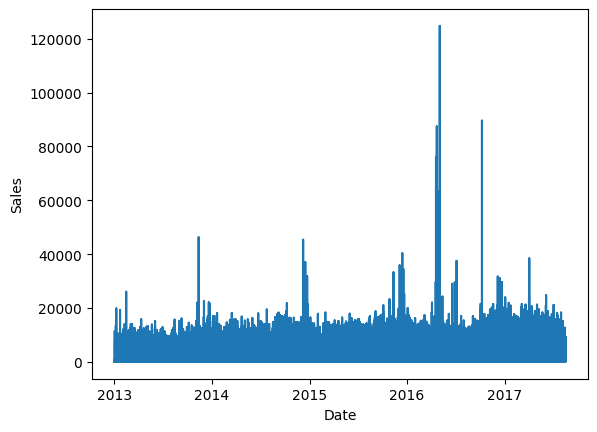

In [ ]:
plt.plot(df.date,df['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

<Axes: xlabel='sales', ylabel='family'>

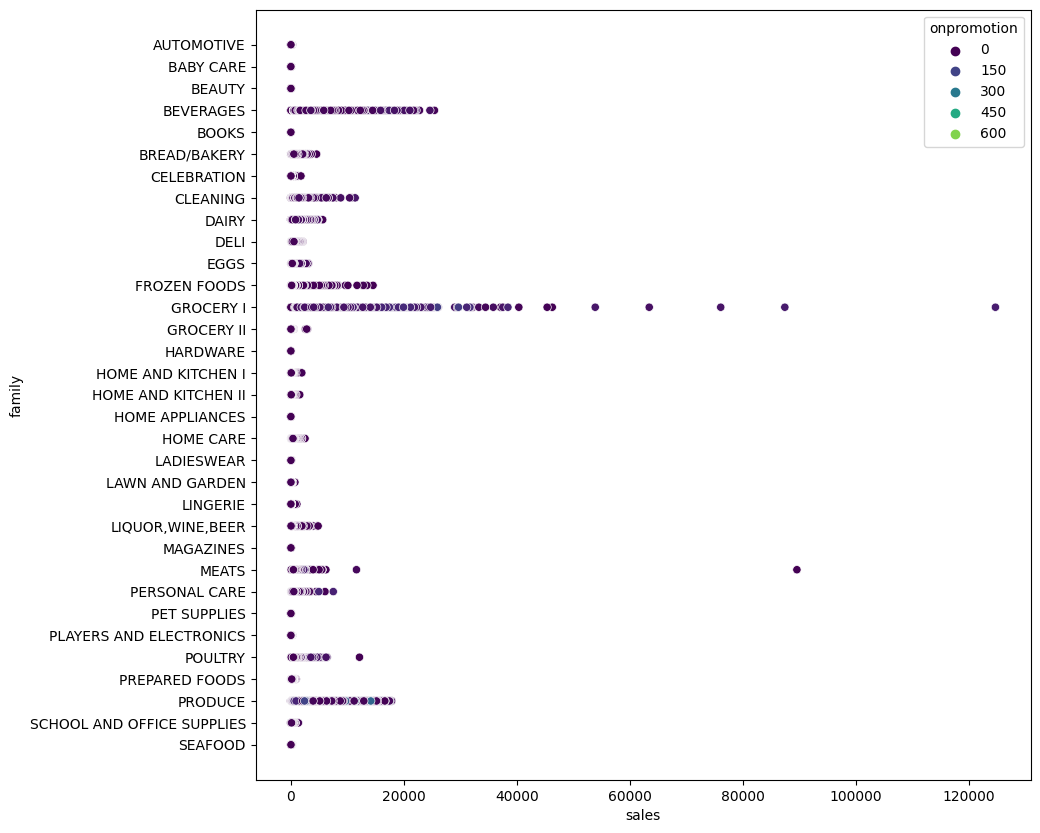

In [ ]:
fig, ax = plt.subplots(figsize =(10,10))
sns.scatterplot(data = df, x = 'sales', y = 'family', hue = df['onpromotion'], palette = 'viridis', ax=ax)

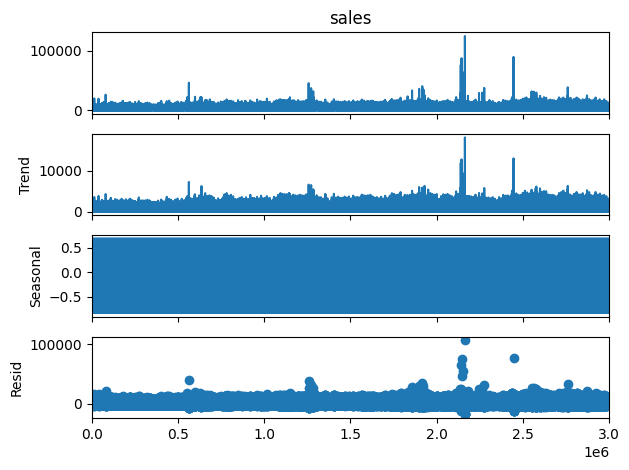

In [ ]:
decompose_ts_add = seasonal_decompose(df.sales,period=7)
decompose_ts_add.plot()
plt.show()

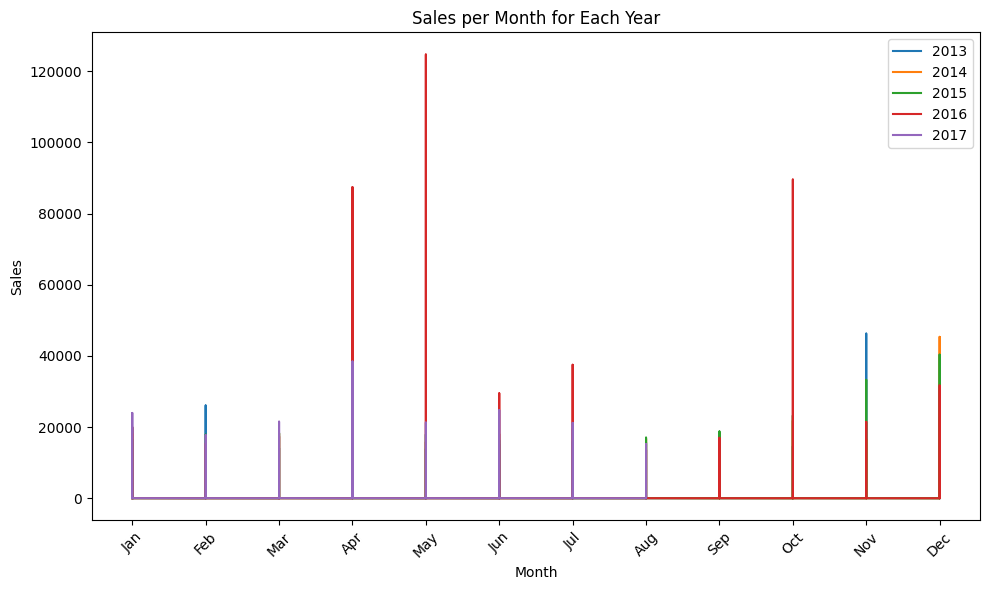

In [ ]:
plt.figure(figsize=(10, 6))
for year in df['Year'].unique():
    year_data = df[df['Year'] == year]
    plt.plot(year_data['Month'], year_data['sales'], label=str(year))

plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Sales per Month for Each Year')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

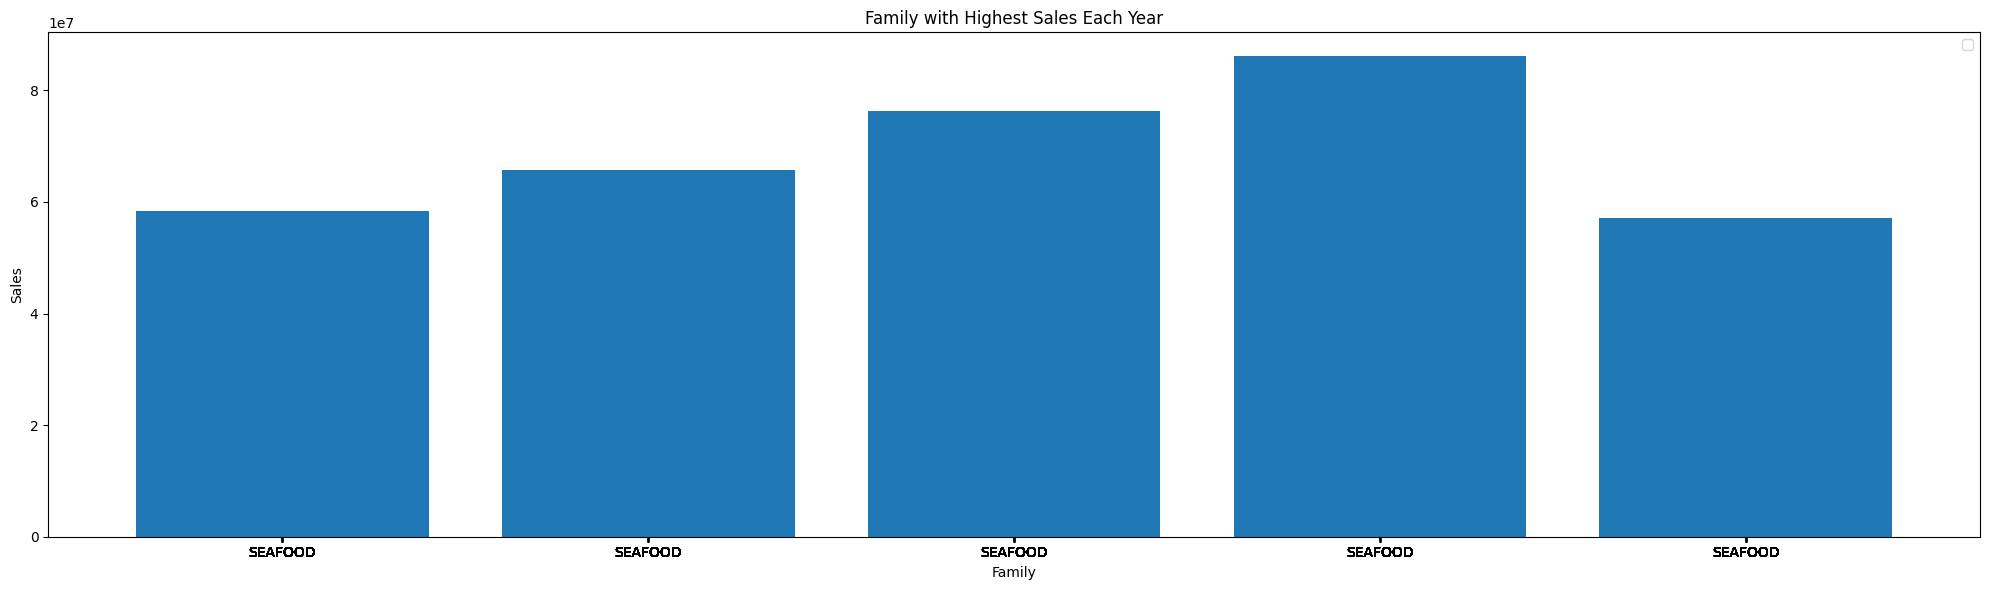

In [ ]:
grouped = df.groupby(['Year', 'family'])['sales'].sum().reset_index()

max_sales_families = grouped.groupby(['family', 'Year'])['sales'].idxmax()
top_family = grouped.loc[max_sales_families]

plt.figure(figsize=(20,6))
plt.bar(top_family['Year'],top_family['sales'], tick_label= top_family['family'])
plt.xlabel('Family')
plt.ylabel('Sales')
plt.title('Family with Highest Sales Each Year')
plt.legend()
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Sales')

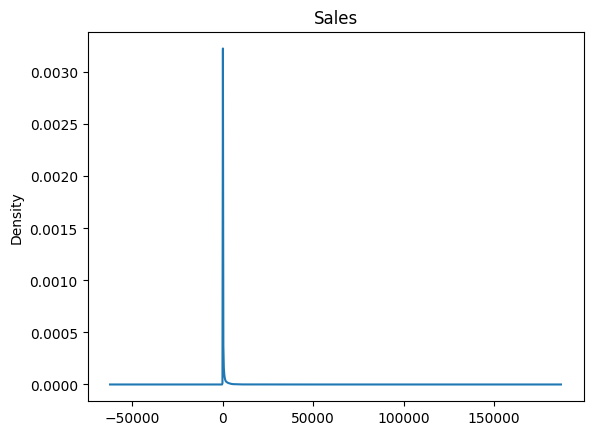

In [ ]:
df['sales'].plot(kind='kde')
plt.title("Sales")

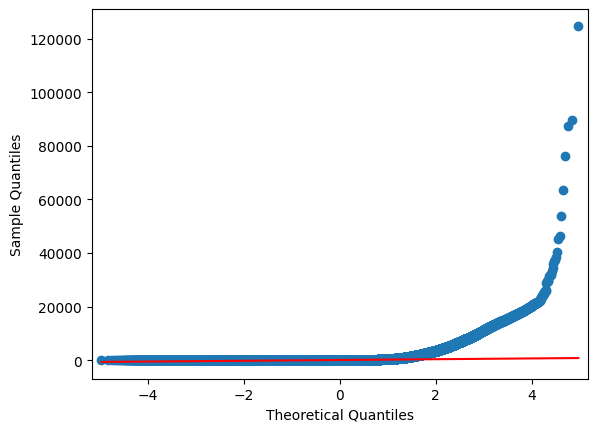

In [ ]:
sm.qqplot(df["sales"],line='q')
py.show()

# Weekly Frequency

In [ ]:
W_df = df.copy()
W_df.set_index('date', inplace =True)
W_df.drop('id', axis = 1, inplace = True)
W_df = W_df.resample('W').mean()

<ipython-input-18-e61be98821cf>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  W_df = W_df.resample('W').mean()


In [ ]:
W_df.index = pd.to_datetime(W_df.index, format = "%Y-%m-%d")

In [ ]:
W_df['Month'] = W_df.index.strftime('%b')
W_df['Year'] = W_df.index.strftime('%Y')
W_df['Day'] = W_df.index.strftime('%d')

In [ ]:
W_df.head()

,store_nbr,sales,onpromotion,Month,Year,Day
date,,,,,,
2013-01-06,27.5,206.843478,0.0,Jan,2013,06
2013-01-13,27.5,190.285220,0.0,Jan,2013,13
2013-01-20,27.5,189.835452,0.0,Jan,2013,20
2013-01-27,27.5,182.152050,0.0,Jan,2013,27
2013-02-03,27.5,198.564267,0.0,Feb,2013,03


In [ ]:
W_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 242 entries, 2013-01-06 to 2017-08-20
Freq: W-SUN
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   store_nbr    242 non-null    float64
 1   sales        242 non-null    float64
 2   onpromotion  242 non-null    float64
 3   Month        242 non-null    object 
 4   Year         242 non-null    object 
 5   Day          242 non-null    object 
dtypes: float64(3), object(3)
memory usage: 13.2+ KB


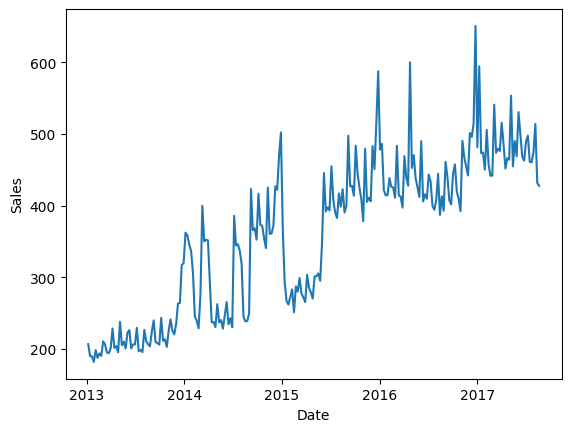

In [ ]:
plt.plot(W_df.index,W_df.sales)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

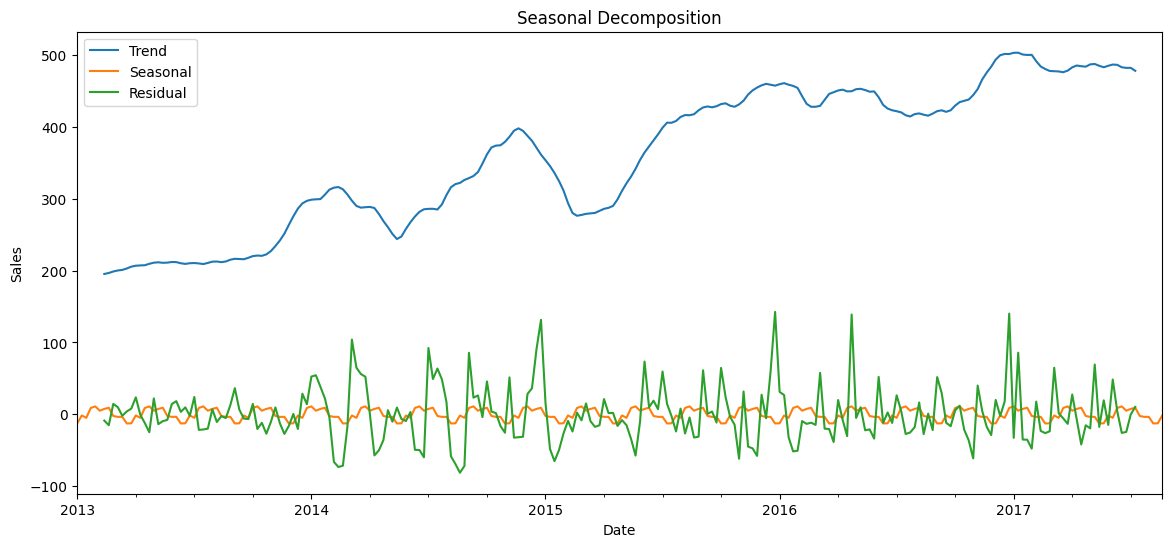

In [ ]:
decompose_W_df = seasonal_decompose(W_df.sales, period=12)

fig, ax = plt.subplots(figsize=(14,6))

# Plot the decomposed components on the custom axis
decompose_W_df.trend.plot(ax = ax, label='Trend')
decompose_W_df.seasonal.plot(ax = ax, label='Seasonal')
decompose_W_df.resid.plot(ax = ax, label='Residual')

# Add labels, legend, and title
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Seasonal Decomposition')
ax.legend()

# Show the plot
plt.show()


<Axes: title={'center': 'Average Sales per Month of each Year'}, xlabel='Month', ylabel='Year'>

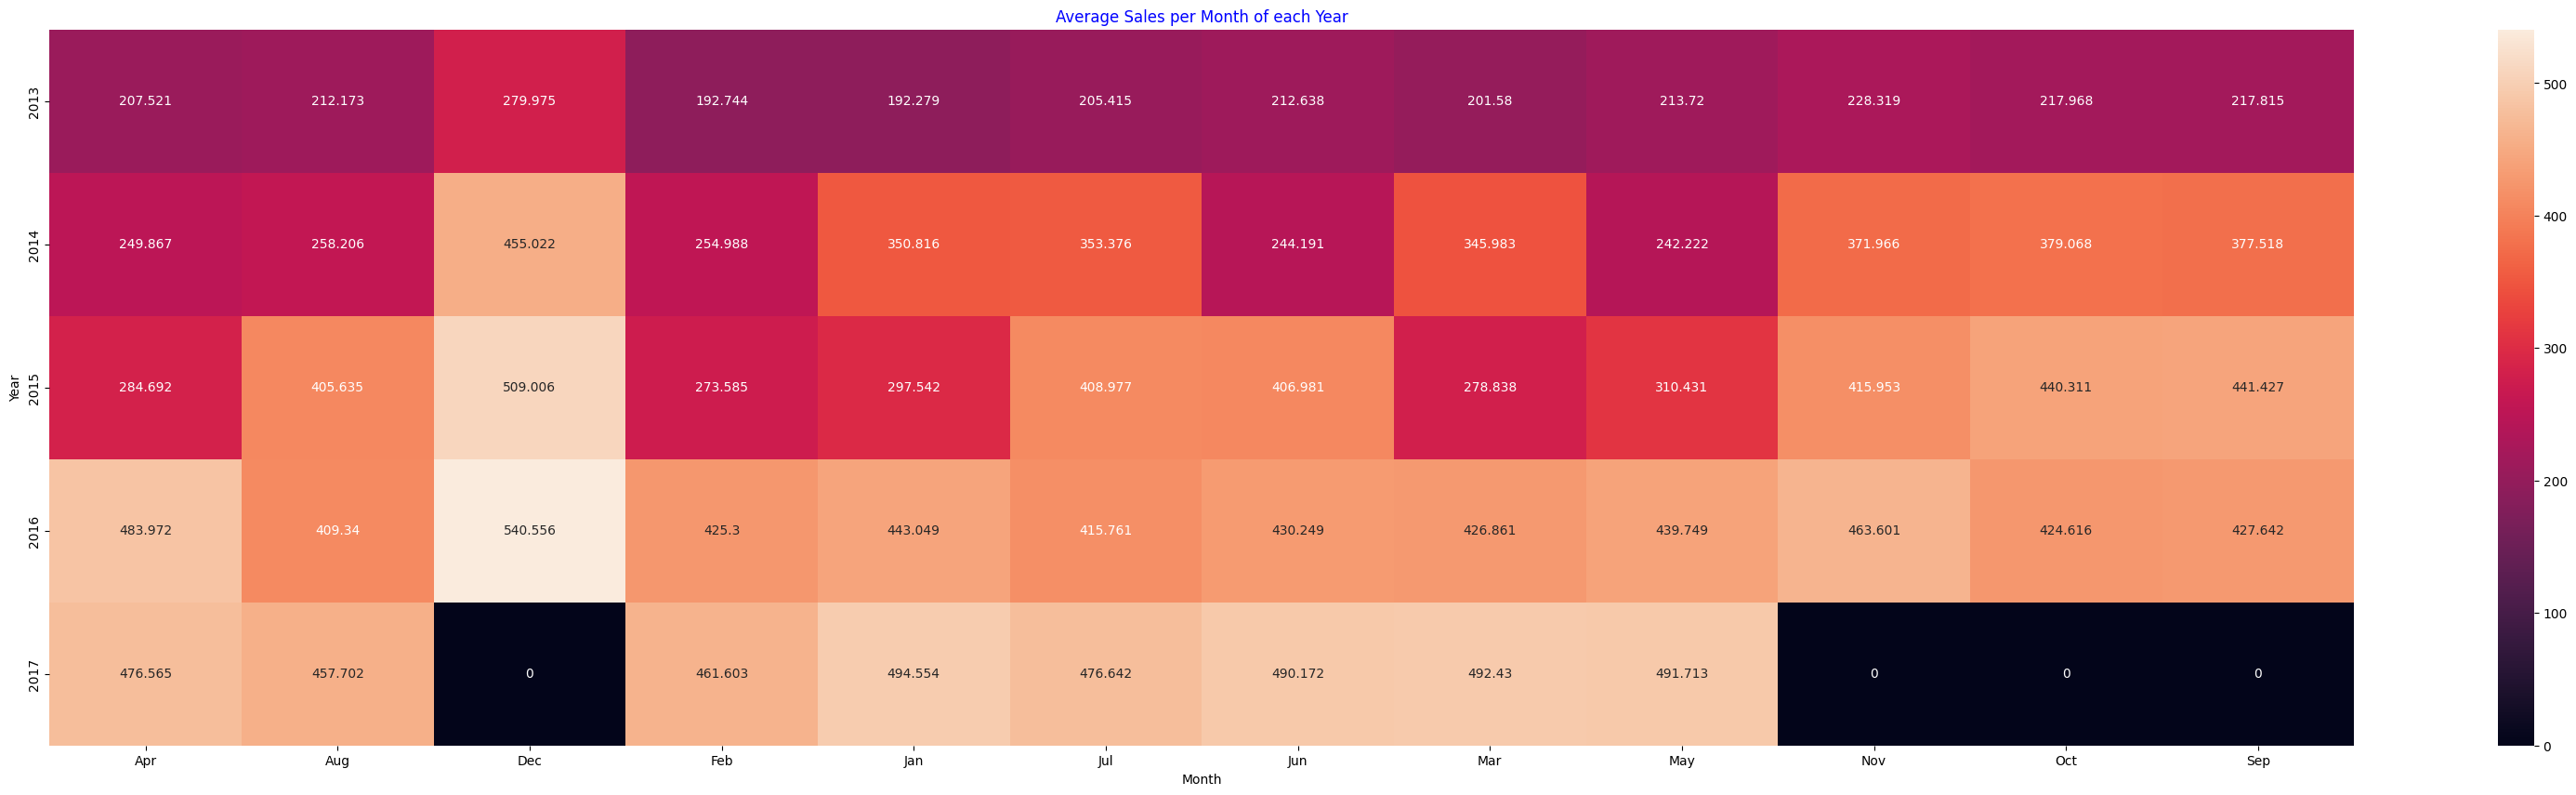

In [ ]:
plt.figure(figsize =(40,10))
plt.title('Average Sales per Month of each Year', c='b')
heatmap1= pd.pivot_table(data = W_df, values = 'sales', index = 'Year', columns = 'Month', fill_value = 0)
sns.heatmap(heatmap1, annot =True, fmt = 'g')

Text(0.5, 1.0, 'Sales')

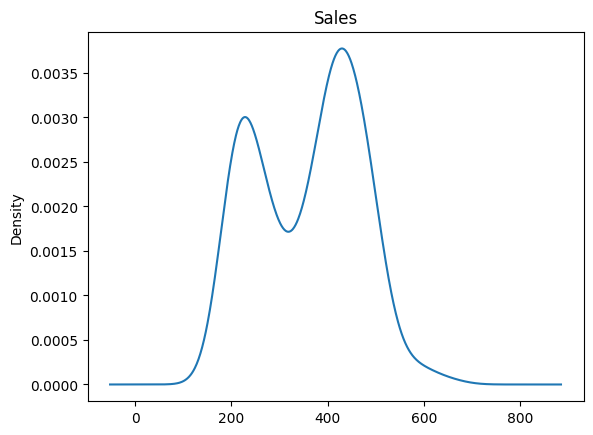

In [ ]:
W_df['sales'].plot(kind='kde')
plt.title("Sales")

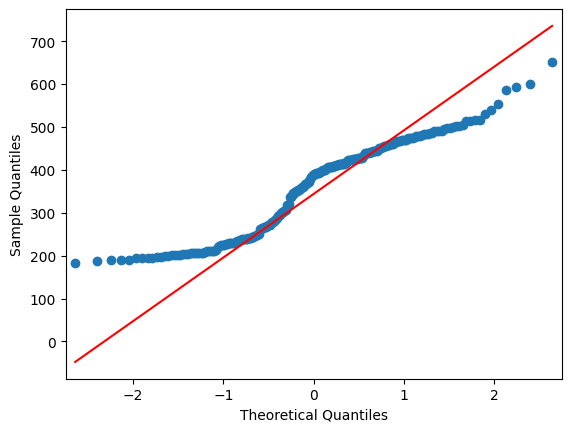

In [ ]:
sm.qqplot(W_df["sales"],line='q')
py.show()

# Month Start Frequency

In [ ]:
# df.date.freq = 'MS'

In [ ]:
MS_df = df.copy()
MS_df.set_index('date', inplace =True)
MS_df.drop('id', axis = 1, inplace = True)
MS_df = MS_df.resample('MS').mean()

<ipython-input-29-b7b2efcf7c7d>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  MS_df = MS_df.resample('MS').mean()


In [ ]:
MS_df.index = pd.to_datetime(MS_df.index, format = "%Y-%m-%d")

In [ ]:
MS_df['Month'] = MS_df.index.strftime('%b')
MS_df['Year'] = MS_df.index.strftime('%Y')
MS_df['Day'] = MS_df.index.strftime('%d')

In [ ]:
MS_df.head()

,store_nbr,sales,onpromotion,Month,Year,Day
date,,,,,,
2013-01-01,27.5,186.952405,0.0,Jan,2013,01
2013-02-01,27.5,193.581846,0.0,Feb,2013,01
2013-03-01,27.5,206.880581,0.0,Mar,2013,01
2013-04-01,27.5,205.639071,0.0,Apr,2013,01
2013-05-01,27.5,209.943594,0.0,May,2013,01


In [ ]:
MS_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56 entries, 2013-01-01 to 2017-08-01
Freq: MS
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   store_nbr    56 non-null     float64
 1   sales        56 non-null     float64
 2   onpromotion  56 non-null     float64
 3   Month        56 non-null     object 
 4   Year         56 non-null     object 
 5   Day          56 non-null     object 
dtypes: float64(3), object(3)
memory usage: 3.1+ KB


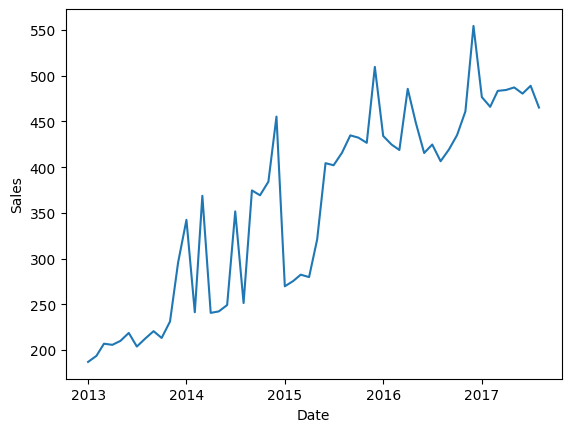

In [ ]:
plt.plot(MS_df.index,MS_df.sales)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

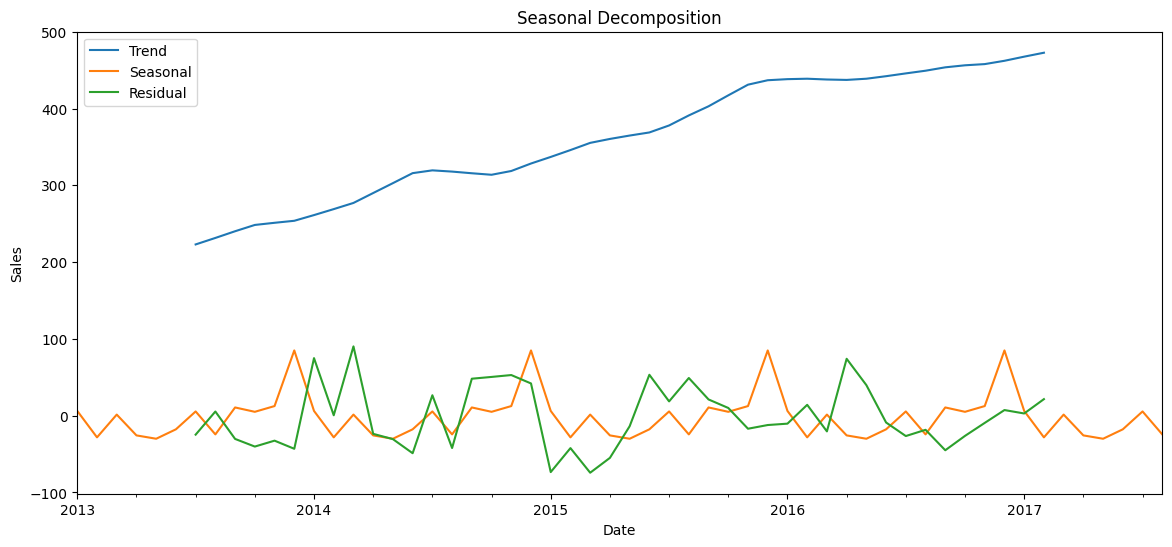

In [ ]:
decompose_MS_df = seasonal_decompose(MS_df.sales, period=12)

fig, ax = plt.subplots(figsize=(14,6))

# Plot the decomposed components on the custom axis
decompose_MS_df.trend.plot(ax = ax, label='Trend')
decompose_MS_df.seasonal.plot(ax = ax, label='Seasonal')
decompose_MS_df.resid.plot(ax = ax, label='Residual')

# Add labels, legend, and title
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Seasonal Decomposition')
ax.legend()

# Show the plot
plt.show()


In [ ]:
average_sales_by_month = df.groupby(['Year', 'Month'])['sales'].mean().reset_index()
months_ordered = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
average_sales_by_month['Month'] = pd.Categorical(average_sales_by_month['Month'], categories=months_ordered, ordered=True)

average_sales_by_month = average_sales_by_month.sort_values(by= ['Year', 'Month'])
average_sales_by_month = pd.DataFrame(average_sales_by_month)
average_sales_by_month

,Year,Month,sales
4,2013,Jan,186.952405
3,2013,Feb,193.581846
7,2013,Mar,206.880581
0,2013,Apr,205.639071
8,2013,May,209.943594
6,2013,Jun,218.655893
5,2013,Jul,203.783364
1,2013,Aug,212.479434
11,2013,Sep,220.593588
10,2013,Oct,213.164266


<Axes: title={'center': 'Average Sales per Month of each year'}, xlabel='Month', ylabel='Year'>

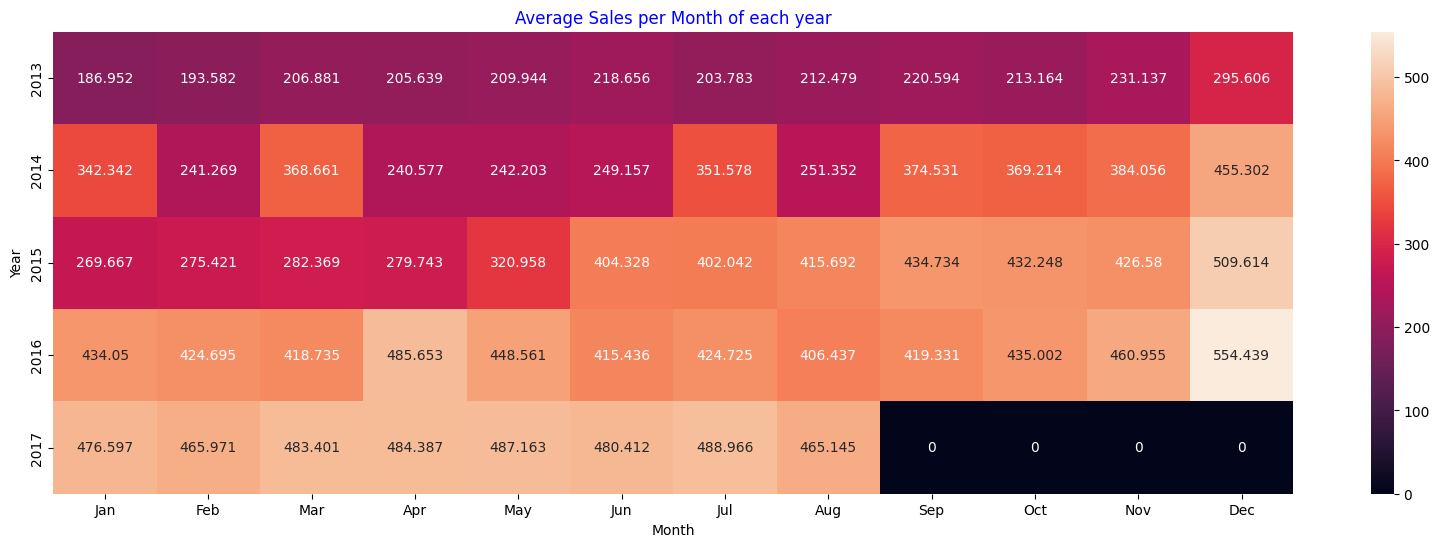

In [ ]:
plt.figure(figsize =(20,6))
plt.title('Average Sales per Month of each year', c='b')
heatmap1= pd.pivot_table(data = average_sales_by_month, values = 'sales', index = 'Year', columns = 'Month', fill_value = 0)
sns.heatmap(heatmap1, annot =True, fmt = 'g')

Text(0.5, 1.0, 'Sales')

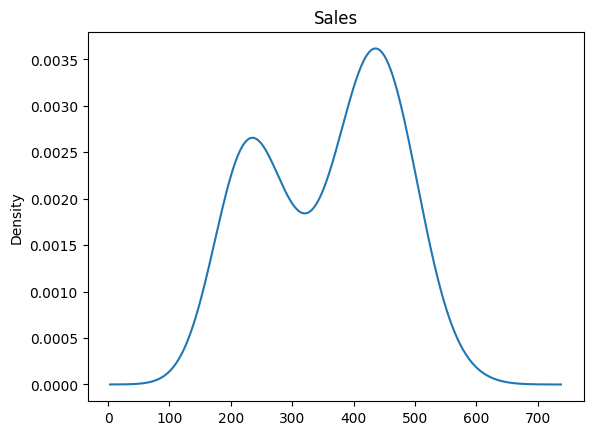

In [ ]:
MS_df['sales'].plot(kind='kde')
plt.title("Sales")

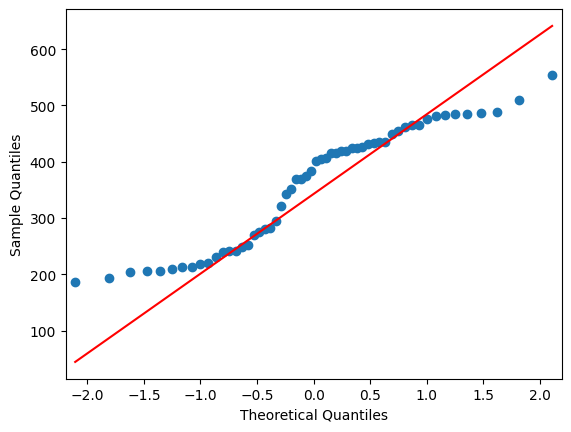

In [ ]:
sm.qqplot(MS_df["sales"],line='q')
py.show()

# Quarterly Data

In [ ]:
quarterly_df = df.copy()

In [ ]:
quarterly_df.set_index('date', inplace =True)

<ipython-input-42-c2790ddc4e74>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  quarterly_data = quarterly_df.resample("Q").mean()


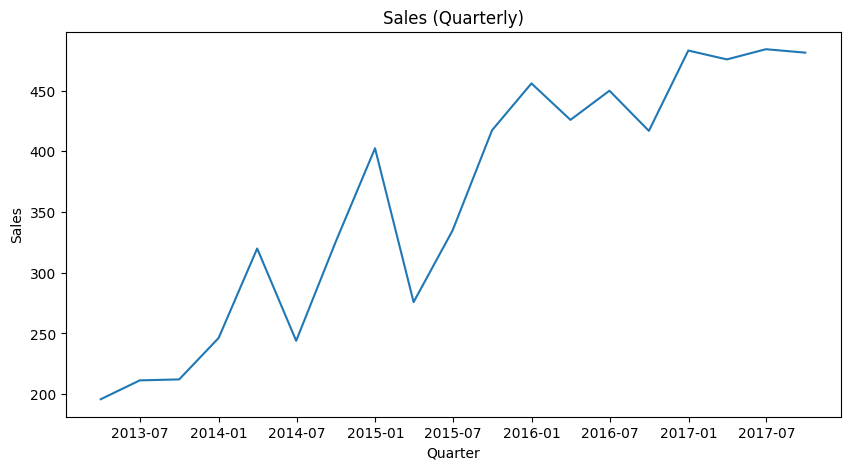

In [ ]:
quarterly_data = quarterly_df.resample("Q").mean()

# Plotting quarter-wise changes
plt.figure(figsize=(10, 5))
plt.title("Sales (Quarterly)")
sns.lineplot(x=quarterly_data.index, y=quarterly_data["sales"])
plt.xlabel("Quarter")
plt.ylabel("Sales")

plt.show()

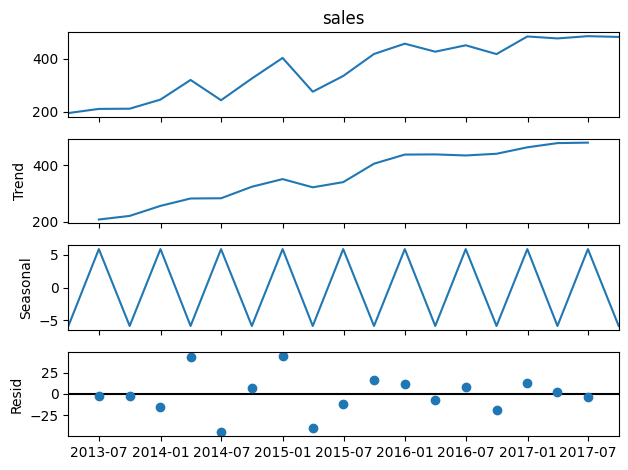

In [ ]:
decompose_ts_add = seasonal_decompose(quarterly_data.sales,period=2)
decompose_ts_add.plot()
plt.show()

Text(0.5, 1.0, 'Sales')

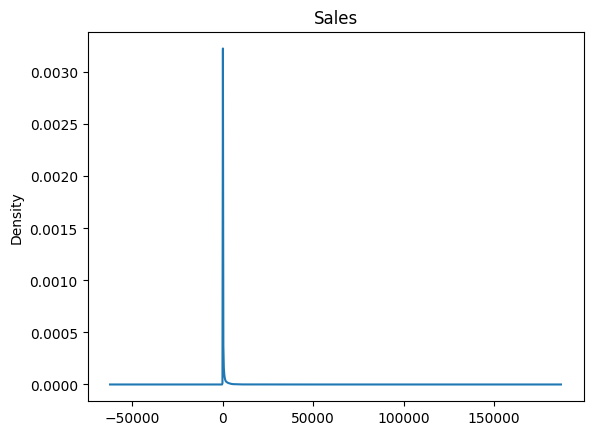

In [ ]:
quarterly_df['sales'].plot(kind='kde')
plt.title("Sales")

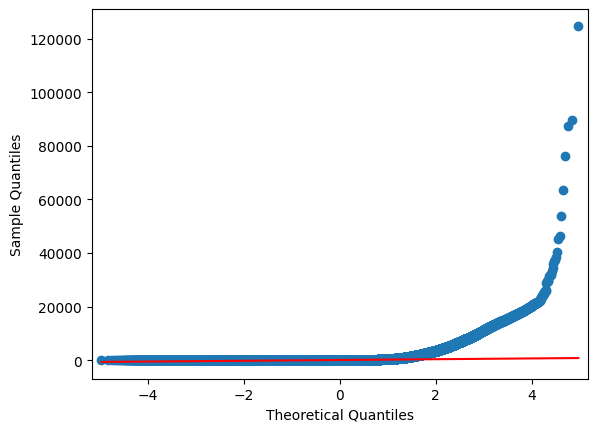

In [ ]:
sm.qqplot(quarterly_df["sales"],line='q')
py.show()

# Test-Train Split for Weekly frequency

In [ ]:
len(W_df)

242

In [ ]:
0.8*len(W_df)

193.60000000000002

In [ ]:
242-(0.8*len(W_df))

48.39999999999998

In [ ]:
train = W_df.head(194)
test = W_df.tail(48)

In [ ]:
train.shape, test.shape

((194, 6), (48, 6))

# Lag Plot

<Axes: xlabel='y(t)', ylabel='y(t + 4)'>

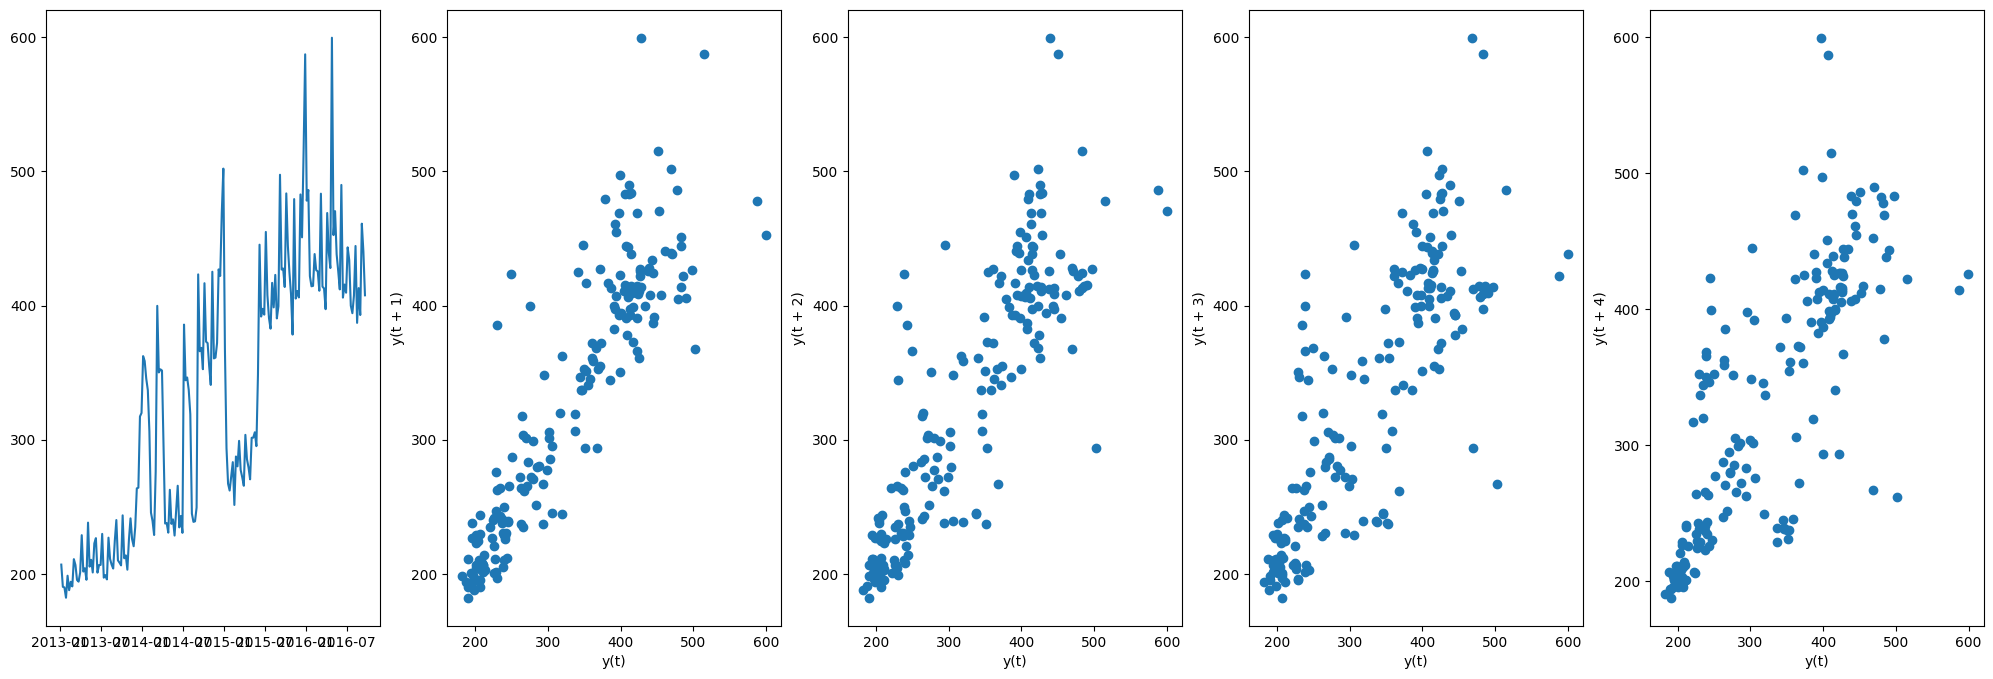

In [ ]:
fig,axs=plt.subplots(1,5,figsize=(25,8))
axs[0].plot(train.index,train["sales"])
pd.plotting.lag_plot(train["sales"],lag=1,ax=axs[1])
pd.plotting.lag_plot(train["sales"],lag=2,ax=axs[2])
pd.plotting.lag_plot(train["sales"],lag=3,ax=axs[3])
pd.plotting.lag_plot(train["sales"],lag=4,ax=axs[4])

# ACF and PACF Plots

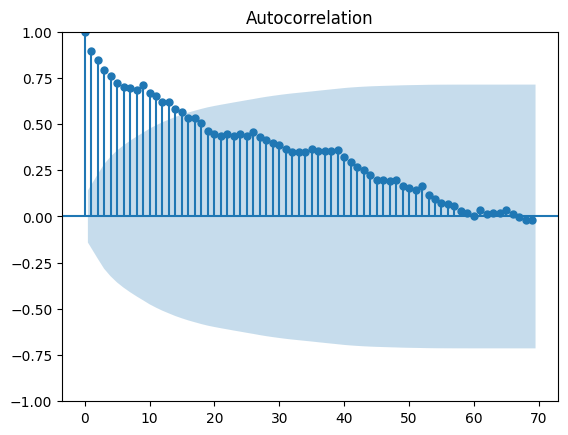

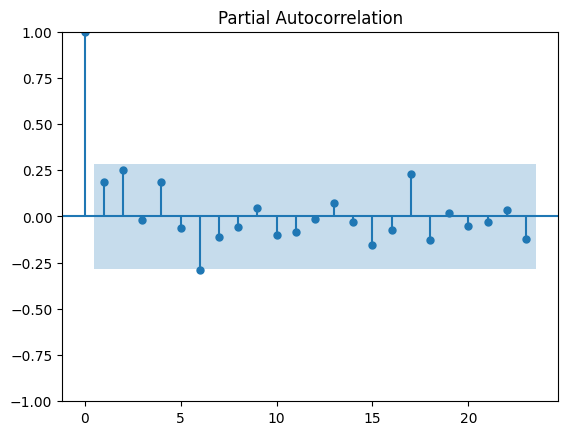

In [ ]:
sgt.plot_acf(train.sales,lags=69)
sgt.plot_pacf(test.sales,lags=23)
plt.show()

# Building Models

# Naive Model

In [ ]:
previous_value = train['sales'].iloc[-1]
test['naive_forecast'] = previous_value

<ipython-input-53-f32447c74ff3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['naive_forecast'] = previous_value


In [ ]:
for i in range(1,len(test["sales"])):
    test['naive_forecast']=test["sales"].iloc[i-1]

<ipython-input-54-bdf169b658bf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['naive_forecast']=test["sales"].iloc[i-1]


In [ ]:
Naive_MAE = mean_absolute_error(test['sales'], test['naive_forecast'])
Naive_MSE = mean_squared_error(test['sales'], test['naive_forecast'], squared=True)
Naive_RMSE = mean_squared_error(test['sales'], test['naive_forecast'], squared=False)
Naive_MAPE = mean_absolute_percentage_error(test['sales'], test['naive_forecast'])

In [ ]:
Naive_MAE

49.78904645715104

In [ ]:
Naive_MSE

4102.802679142616

In [ ]:
Naive_RMSE

64.05312388277886

In [ ]:
Naive_MAPE

0.0986105449321761

# ADF Test

In [ ]:
def adf_test(Data):
  result=sts.adfuller(Data)
  ''' perform Augmented Dickey Fuller Test on Given Data Set'''
  labels=["ADF test statistic","p-value","# lags used","# obsesrvations"]
  out = pd.Series(result[0:4], index=labels)

  if result[1]<=0.05:
      print('The time series is likely stationary.')
      print(out)
  else:
      print('The time series is likely non-stationary.')
      print(out)

In [ ]:
adf_test(train['sales'])

The time series is likely non-stationary.
ADF test statistic     -1.546243
p-value                 0.510524
# lags used             9.000000
# obsesrvations       184.000000
dtype: float64


# Moving Average Model

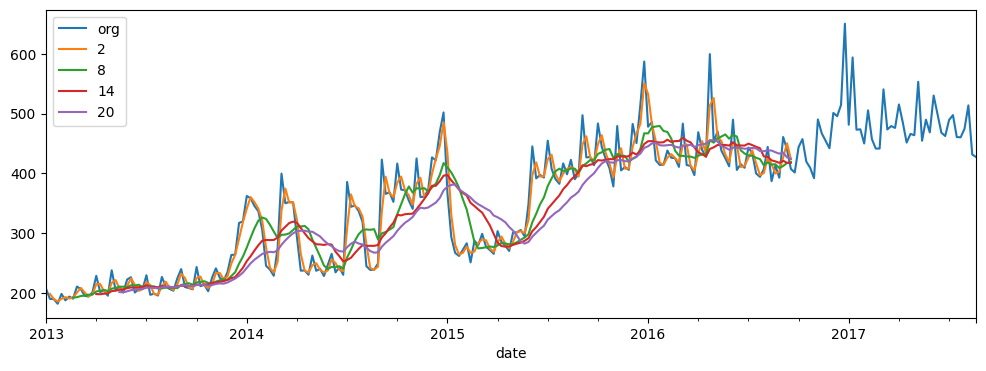

In [ ]:
plt.figure(figsize=(12,4))
W_df.sales.plot(label="org")
for i in range(2,24,6):
    train["sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

# Prediction for Test Data using Moving Average Model

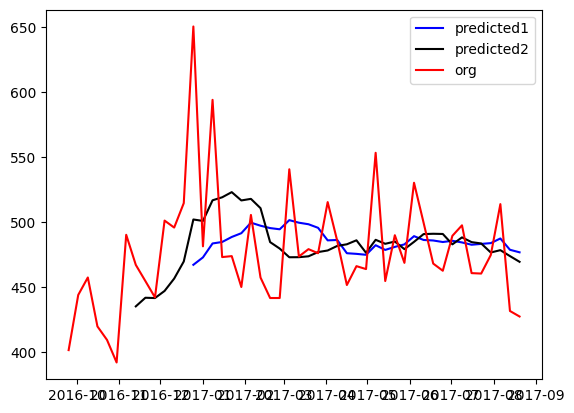

In [ ]:
    plt.plot(test["sales"].rolling(14).mean(), label = 'predicted1', color = 'b')#.plot(label=str(14))
    plt.plot(test["sales"].rolling(8).mean(), label = 'predicted2', color = 'k')
    plt.plot(test['sales'], label = 'org', color = 'r')
    plt.legend()
    plt.show()

In [ ]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

In [ ]:
Mov_Avg_MAPE = MAPE(test["sales"].rolling(8).mean(),test['sales'])
Mov_Avg_MAPE

6.42576541611496

# Exponential Smoothing Models

# Simple Exponential Smoothing

In [ ]:
alpha = 0.15

In [ ]:
SES_Model= SimpleExpSmoothing(train['sales']).fit(smoothing_level=alpha,optimized=False)
SES_Model.fittedvalues

date
2013-01-06    206.843478
2013-01-13    206.843478
2013-01-20    204.359739
2013-01-27    202.181096
2013-02-03    199.176739
                 ...    
2016-08-21    420.400611
2016-08-28    419.288857
2016-09-04    415.333348
2016-09-11    422.186657
2016-09-18    424.900221
Freq: W-SUN, Length: 194, dtype: float64

In [ ]:
SES_forecast = SES_Model.fittedvalues

In [ ]:
train.tail()

,store_nbr,sales,onpromotion,Month,Year,Day
date,,,,,,
2016-08-21,27.5,412.988919,5.186147,Aug,2016,21
2016-08-28,27.5,392.918792,4.759981,Aug,2016,28
2016-09-04,27.5,461.022080,4.719897,Sep,2016,04
2016-09-11,27.5,440.277084,4.488296,Sep,2016,11
2016-09-18,27.5,407.614706,5.603656,Sep,2016,18


**Metrics for SES Train Data**

In [ ]:
mean_absolute_percentage_error(train['sales'], SES_forecast)

0.10285675657674073

**Metrics for SES Test Data**

In [ ]:
SES_test_forecast = SES_Model.predict(start = test['sales'].index[0], end = test['sales'].index[-1])

MAPE

In [ ]:
SES_MAPE = mean_absolute_percentage_error(test['sales'], SES_test_forecast)
SES_MAPE

0.11424229016538523

# Double Exponential Smoothing

In [ ]:
DES_Model = ExponentialSmoothing(train['sales'], trend='add').fit()
DES_forecast = DES_Model.fittedvalues
DES_forecast.head()

date
2013-01-06    191.112968
2013-01-13    202.234933
2013-01-20    195.601246
2013-01-27    192.933732
2013-02-03    187.048192
Freq: W-SUN, dtype: float64

In [ ]:
DES_forecast.tail()

date
2016-08-21    404.165385
2016-08-28    410.858324
2016-09-04    400.383517
2016-09-11    440.314835
2016-09-18    441.326629
Freq: W-SUN, dtype: float64

Metrics for train data

In [ ]:
mean_absolute_percentage_error(train['sales'], DES_forecast)

0.08264552806419515

Metrics for Test Data

In [ ]:
DES_test_forecast = DES_Model.predict(start = test['sales'].index[0], end = test['sales'].index[-1])

In [ ]:
DES_MAPE = mean_absolute_percentage_error(test['sales'], DES_test_forecast)
DES_MAPE

0.07589253565226373

# Triple Exponential Smoothing (Trend = Linear, Seasonality = Additive)

In [ ]:
TES_Model = ExponentialSmoothing(train['sales'], trend='add', seasonal = 'add').fit()
TES_forecast = TES_Model.fittedvalues
TES_forecast.head()

date
2013-01-06    208.729585
2013-01-13    188.869690
2013-01-20    164.954172
2013-01-27    176.827663
2013-02-03    181.786655
Freq: W-SUN, dtype: float64

In [ ]:
TES_forecast.tail()

date
2016-08-21    394.413706
2016-08-28    414.661885
2016-09-04    488.472227
2016-09-11    423.336701
2016-09-18    426.503944
Freq: W-SUN, dtype: float64

In [ ]:
mean_absolute_percentage_error(train['sales'], TES_forecast)

0.06109388190291072

In [ ]:
TES_test_forecast = TES_Model.predict(start = test['sales'].index[0], end = test['sales'].index[-1])

In [ ]:
mean_absolute_percentage_error(test['sales'], TES_test_forecast)

0.1792632966759945

# Triple Exponential Smoothing (Trend = Non-Linear, Seasonality = Additive)

In [ ]:
TES_Model2 = ExponentialSmoothing(train['sales'], trend='mul', seasonal = 'add').fit()
TES_forecast2 = TES_Model2.fittedvalues
TES_forecast2.head()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


date
2013-01-06    219.526189
2013-01-13    184.349190
2013-01-20    161.502339
2013-01-27    171.820804
2013-02-03    174.798341
Freq: W-SUN, dtype: float64

In [ ]:
TES_forecast2.tail()

date
2016-08-21    393.252232
2016-08-28    412.180369
2016-09-04    489.038659
2016-09-11    426.201480
2016-09-18    427.809730
Freq: W-SUN, dtype: float64

In [ ]:
mean_absolute_percentage_error(train['sales'], TES_forecast2)

0.0639859516232368

In [ ]:
TES_test_forecast2 = TES_Model2.predict(start = test['sales'].index[0], end = test['sales'].index[-1])

In [ ]:
TES_MAPE = mean_absolute_percentage_error(test['sales'], TES_test_forecast2)
TES_MAPE

0.1735365536728679

# ARIMA Models

## Defining LLR Test

In [ ]:
def LLR_test(mod_1, mod_2, DF = 1):
  L1 = mod_1.fit().llf
  L2 = mod_2.fit().llf
  LR = 2*(L2 - L1)
  p = chi2.sf(LR, DF).round(3)
  return p

In [ ]:
ARIMA_Model1 = ARIMA(train["sales"],order=(1,1,1))
ARIMA_Model2 = ARIMA(train["sales"],order=(2,2,2))
LLR_test(ARIMA_Model1,ARIMA_Model2)

0.018

In [ ]:
ARIMA_Model2 = ARIMA(train["sales"],order=(2,1,2))
ARIMA_Model3 = ARIMA(train["sales"],order=(3,2,3))
LLR_test(ARIMA_Model2,ARIMA_Model3)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


0.324

In [ ]:
ARIMA_Model3 = ARIMA(train["sales"],order=(3,2,3))
ARIMA_Model4 = ARIMA(train["sales"],order=(4,1,4))
LLR_test(ARIMA_Model3,ARIMA_Model4)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/st

0.0

In [ ]:
ARIMA_result3 = ARIMA_Model3.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:
ARIMA_Forecast = ARIMA_result3.fittedvalues

# Residual Analysis for ARIMA Model 3

In [ ]:
train['ARIMA3_res_ret'] = ARIMA_result3.resid

<ipython-input-94-c0423fbbffba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['ARIMA3_res_ret'] = ARIMA_result3.resid


In [ ]:
train['ARIMA3_res_ret']

date
2013-01-06    206.843478
2013-01-13   -119.910466
2013-01-20     15.371997
2013-01-27      2.767891
2013-02-03     23.610154
                 ...    
2016-08-21     -4.918049
2016-08-28    -14.411033
2016-09-04     70.077549
2016-09-11    -14.407613
2016-09-18    -34.894296
Freq: W-SUN, Name: ARIMA3_res_ret, Length: 194, dtype: float64

In [ ]:
train['ARIMA3_res_ret'].mean()

0.7283841732593536

In [ ]:
train['ARIMA3_res_ret'].var()

1973.8300998271154

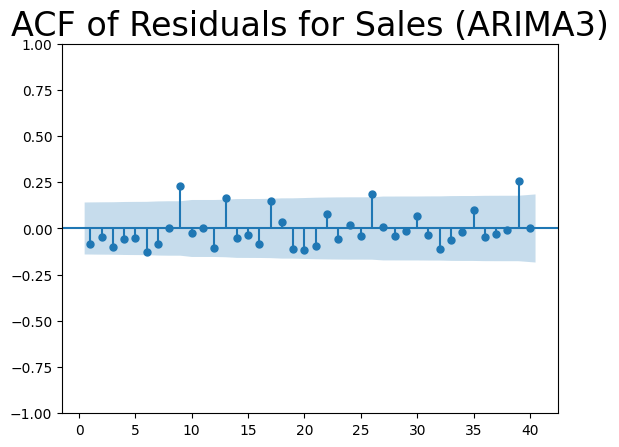

In [ ]:
sgt.plot_acf(train['ARIMA3_res_ret'], lags = 40, zero = False)
plt.title("ACF of Residuals for Sales (ARIMA3)", size = 24)
plt.show()

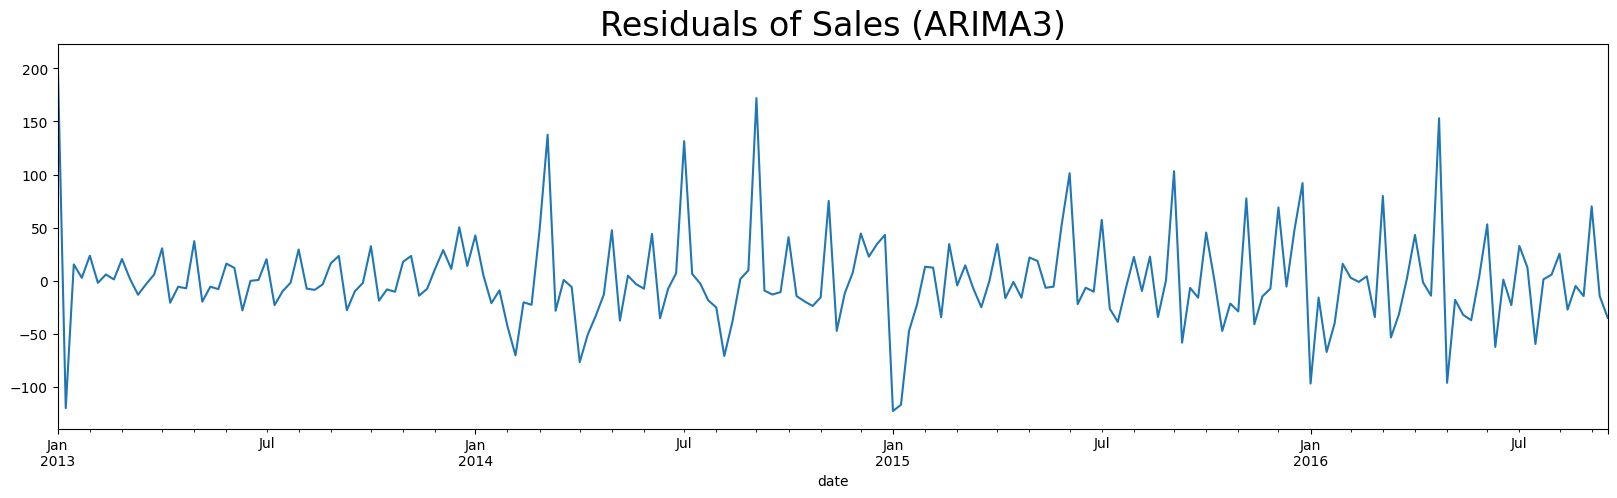

In [ ]:
train['ARIMA3_res_ret'].plot(figsize = (20,5))
plt.title("Residuals of Sales (ARIMA3)", size = 24)
plt.show()

# Predictions for Test Data using ARIMA Model 3

In [ ]:
ARIMA_test_forecast = ARIMA_result3.predict(start = test['sales'].index[0], end = test['sales'].index[-1])

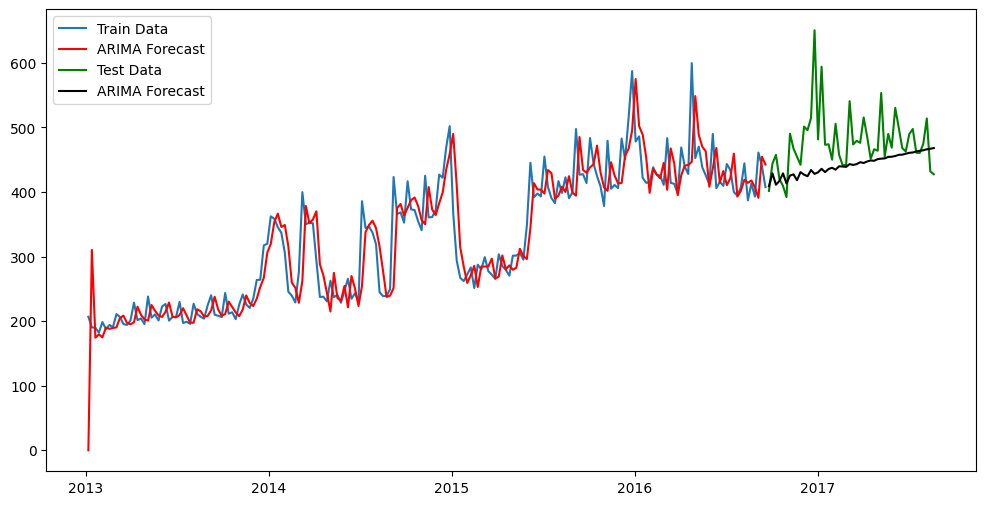

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train['sales'], label='Train Data')
plt.plot(ARIMA_Forecast, label='ARIMA Forecast', color='red')
plt.plot(test['sales'], label = 'Test Data', color ='g' )
plt.plot(ARIMA_test_forecast, label='ARIMA Forecast', color='k')
plt.legend()
plt.show()

In [ ]:
ARIMA_MAPE = mean_absolute_percentage_error(test['sales'],ARIMA_test_forecast)
ARIMA_MAPE

0.07897229337394229

# SARIMAX Model

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


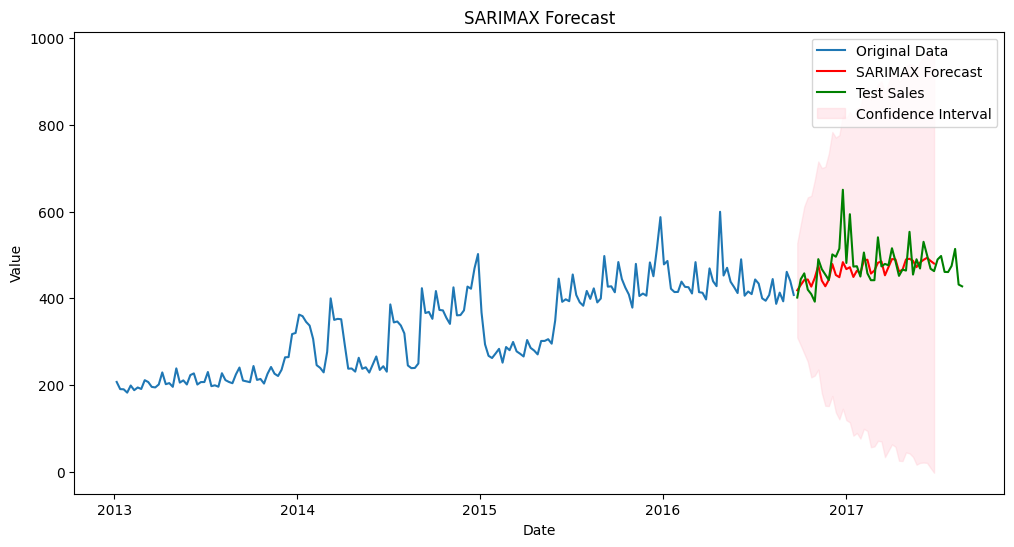

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

# Specify the order of the SARIMA model (p, d, q) and seasonal order (P, D, Q, S)
p = 5  # Autoregressive (AR) order
d = 1  # Integration (I) order
q = 5  # Moving Average (MA) order
P = 3  # Seasonal AR order
D = 1  # Seasonal Integration order
Q = 3  # Seasonal MA order
S = 7  # Seasonal period (e.g., 7 for Weekly data)

# Create and fit the SARIMAX model
SARIMAX_Model = sm.tsa.SARIMAX(train['sales'], order=(p, d, q), seasonal_order=(P, D, Q, S))
SARIMAX_Results = SARIMAX_Model.fit()

# Make predictions
SARIMAX_Forecast_Steps = 40  # Adjust as needed
SARIMAX_Forecast = SARIMAX_Results.get_forecast(steps = SARIMAX_Forecast_Steps)

# Get confidence intervals
Forecast_Conf_Int = SARIMAX_Forecast.conf_int()

# Plot the original data and forecast
plt.figure(figsize=(12, 6))
plt.plot(train['sales'], label='Original Data')
plt.plot(SARIMAX_Forecast.predicted_mean, label='SARIMAX Forecast', color='red')
plt.plot(test['sales'], label ='Test Sales', color = 'g')

# Fill confidence interval
plt.fill_between(
    Forecast_Conf_Int.index,
    Forecast_Conf_Int.iloc[:, 0],
    Forecast_Conf_Int.iloc[:, 1],
    color='pink',
    alpha=0.3,
    label='Confidence Interval'
)

plt.legend()
plt.title('SARIMAX Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


# Predictions for Test Data using SARIMAX Model

In [ ]:
SARIMAX_test_forecast = SARIMAX_Results.predict(start = test['sales'].index[0], end = test['sales'].index[-1])

In [ ]:
SARIMAX_MAPE = mean_absolute_percentage_error(test['sales'],SARIMAX_test_forecast)
SARIMAX_MAPE

0.058681915671409964

# LSTM

In [ ]:
W_df.head()

,store_nbr,sales,onpromotion,Month,Year,Day
date,,,,,,
2013-01-06,27.5,206.843478,0.0,Jan,2013,06
2013-01-13,27.5,190.285220,0.0,Jan,2013,13
2013-01-20,27.5,189.835452,0.0,Jan,2013,20
2013-01-27,27.5,182.152050,0.0,Jan,2013,27
2013-02-03,27.5,198.564267,0.0,Feb,2013,03


In [ ]:
W_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 242 entries, 2013-01-06 to 2017-08-20
Freq: W-SUN
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   store_nbr    242 non-null    float64
 1   sales        242 non-null    float64
 2   onpromotion  242 non-null    float64
 3   Month        242 non-null    object 
 4   Year         242 non-null    object 
 5   Day          242 non-null    object 
dtypes: float64(3), object(3)
memory usage: 13.2+ KB


In [ ]:
W_df.iloc[:,1]

date
2013-01-06    206.843478
2013-01-13    190.285220
2013-01-20    189.835452
2013-01-27    182.152050
2013-02-03    198.564267
                 ...    
2017-07-23    460.504663
2017-07-30    474.732392
2017-08-06    513.884368
2017-08-13    431.730145
2017-08-20    427.492801
Freq: W-SUN, Name: sales, Length: 242, dtype: float64

In [ ]:
dataframe = W_df.reset_index()
dataframe

,date,store_nbr,sales,onpromotion,Month,Year,Day
0,2013-01-06,27.5,206.843478,0.000000,Jan,2013,06
1,2013-01-13,27.5,190.285220,0.000000,Jan,2013,13
2,2013-01-20,27.5,189.835452,0.000000,Jan,2013,20
3,2013-01-27,27.5,182.152050,0.000000,Jan,2013,27
4,2013-02-03,27.5,198.564267,0.000000,Feb,2013,03
...,...,...,...,...,...,...,...
237,2017-07-23,27.5,460.504663,6.999359,Jul,2017,23
238,2017-07-30,27.5,474.732392,6.467452,Jul,2017,30
239,2017-08-06,27.5,513.884368,6.062530,Aug,2017,06
240,2017-08-13,27.5,431.730145,5.984848,Aug,2017,13


In [ ]:
dataframe = dataframe.iloc[:,2]
dataframe

0      206.843478
1      190.285220
2      189.835452
3      182.152050
4      198.564267
          ...    
237    460.504663
238    474.732392
239    513.884368
240    431.730145
241    427.492801
Name: sales, Length: 242, dtype: float64

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D
from pandas import read_csv




#Convert pandas dataframe to numpy array
dataset = dataframe.values
dataset = dataset.astype('float32') #COnvert values to float

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
#scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
#dataset = scaler.fit_transform(dataset)

#We cannot use random way of splitting dataset into train and test as
#the sequence of events is important for time series.
#So let us take first 60% values for train and the remaining 1/3 for testing
# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]


# We cannot fit the model like we normally do for image processing where we have
#X and Y. We need to transform our data into something that looks like X and Y values.
# This way it can be trained on a sequence rather than indvidual datapoints.
# Let us convert into n number of columns for X where we feed sequence of numbers
#then the final column as Y where we provide the next number in the sequence as output.
# So let us convert an array of values into a dataset matrix

#seq_size is the number of previous time steps to use as
#input variables to predict the next time period.

#creates a dataset where X is the number of passengers at a given time (t, t-1, t-2...)
#and Y is the number of passengers at the next time (t + 1).

def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size)]
        x.append(window)
        y.append(dataset[i+seq_size])

    return np.array(x),np.array(y)


seq_size = 10  # Number of time steps to look back
#Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)



print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))


######################################################
# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('Single LSTM with hidden Dense...')
LSTM_model = Sequential()
LSTM_model.add(LSTM(64, input_shape=(None, seq_size)))
LSTM_model.add(Dense(32))
LSTM_model.add(Dense(1))
LSTM_model.compile(loss='mean_squared_error', optimizer='adam')
#monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20,
                      #  verbose=1, mode='auto', restore_best_weights=True)




Shape of training set: (182, 10)
Shape of test set: (38, 10)
Single LSTM with hidden Dense...


In [ ]:
print(LSTM_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                19200     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21313 (83.25 KB)
Trainable params: 21313 (83.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
LSTM_model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=100)

Epoch 1/100
6/6 - 3s - loss: 121082.5469 - val_loss: 238227.3906 - 3s/epoch - 518ms/step
Epoch 2/100
6/6 - 0s - loss: 120244.0312 - val_loss: 237130.2344 - 92ms/epoch - 15ms/step
Epoch 3/100
6/6 - 0s - loss: 119520.1875 - val_loss: 236034.3125 - 81ms/epoch - 13ms/step
Epoch 4/100
6/6 - 0s - loss: 118791.6406 - val_loss: 235102.7344 - 79ms/epoch - 13ms/step
Epoch 5/100
6/6 - 0s - loss: 118129.7656 - val_loss: 234032.5469 - 88ms/epoch - 15ms/step
Epoch 6/100
6/6 - 0s - loss: 117273.9141 - val_loss: 232580.7656 - 88ms/epoch - 15ms/step
Epoch 7/100
6/6 - 0s - loss: 116343.2344 - val_loss: 231341.6250 - 78ms/epoch - 13ms/step
Epoch 8/100
6/6 - 0s - loss: 115468.2656 - val_loss: 230021.8125 - 83ms/epoch - 14ms/step
Epoch 9/100
6/6 - 0s - loss: 114551.0469 - val_loss: 228617.4219 - 101ms/epoch - 17ms/step
Epoch 10/100
6/6 - 0s - loss: 113571.1875 - val_loss: 227129.9531 - 89ms/epoch - 15ms/step
Epoch 11/100
6/6 - 0s - loss: 112505.3594 - val_loss: 225379.2344 - 92ms/epoch - 15ms/step
Epoch 12

In [ ]:
trainPredict = LSTM_model.predict(trainX)

6/6 [==============================] - 0s 3ms/step


In [ ]:
LSTM_trainMAPE = mean_absolute_percentage_error(trainY, trainPredict)
print('Train Score: %.2f MAPE' % (LSTM_trainMAPE))

Train Score: 0.27 MAPE


# Predictions for Test Data using LSTM Model

In [ ]:
testPredict = LSTM_model.predict(testX)

2/2 [==============================] - 0s 6ms/step


In [ ]:
LSTM_testMAPE = mean_absolute_percentage_error(testY, testPredict)
print('Train Score: %.2f MAPE' % (LSTM_testMAPE))

Train Score: 0.35 MAPE


# Prophet Model

In [ ]:
prophet_df = df.copy()

In [ ]:
prophet_df.head()

,id,date,store_nbr,family,sales,onpromotion,Month,Year,Day
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Jan,2013,01
1,1,2013-01-01,1,BABY CARE,0.0,0,Jan,2013,01
2,2,2013-01-01,1,BEAUTY,0.0,0,Jan,2013,01
3,3,2013-01-01,1,BEVERAGES,0.0,0,Jan,2013,01
4,4,2013-01-01,1,BOOKS,0.0,0,Jan,2013,01


In [ ]:
prophet_df.drop(['id','store_nbr',	'family',	'onpromotion'	,'Month'	,'Year'	,'Day'], axis = 1,inplace = True)

In [ ]:
prophet_df.head()

,date,sales
0,2013-01-01,0.0
1,2013-01-01,0.0
2,2013-01-01,0.0
3,2013-01-01,0.0
4,2013-01-01,0.0


In [ ]:
prophet_df.date = pd.to_datetime(prophet_df.date, format = "%Y-%m-%d")

In [ ]:
prophet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   date    datetime64[ns]
 1   sales   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 45.8 MB


In [ ]:
prophet_df.rename(columns = {'date':'ds','sales':'y'}, inplace = True)

In [ ]:
prophet_df.head()

,ds,y
0,2013-01-01,0.0
1,2013-01-01,0.0
2,2013-01-01,0.0
3,2013-01-01,0.0
4,2013-01-01,0.0


In [ ]:
W_prophet_df = prophet_df.copy()
W_prophet_df.set_index('ds', inplace =True)
W_prophet_df = W_prophet_df.resample('W').mean()

In [ ]:
W_prophet_df.head()

,y
ds,
2013-01-06,206.843478
2013-01-13,190.285220
2013-01-20,189.835452
2013-01-27,182.152050
2013-02-03,198.564267


In [ ]:
W_prophet_df.reset_index(inplace = True)

In [ ]:
W_prophet_df.head()

,ds,y
0,2013-01-06,206.843478
1,2013-01-13,190.285220
2,2013-01-20,189.835452
3,2013-01-27,182.152050
4,2013-02-03,198.564267


In [ ]:
W_prophet_df.drop('id', axis =1, inplace = True)

KeyError: "['id'] not found in axis"

In [ ]:
W_prophet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      242 non-null    datetime64[ns]
 1   y       242 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.9 KB


In [ ]:
W_prophet_df.head()

,ds,y
0,2013-01-06,206.843478
1,2013-01-13,190.285220
2,2013-01-20,189.835452
3,2013-01-27,182.152050
4,2013-02-03,198.564267


In [ ]:
W_prophet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      242 non-null    datetime64[ns]
 1   y       242 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.9 KB


In [ ]:
train_size = int(len(W_prophet_df) * 0.8)
proph_train, proph_test = W_prophet_df[:train_size], W_prophet_df[train_size:]

In [ ]:
m = Prophet()
m.fit(proph_train)
#make_future_dataframe
#future = m.predict(proph_test)
#future.tail()

forecast = m.predict(proph_test)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnr34uq24/v0iw36ew.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnr34uq24/hjou0s1n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16417', 'data', 'file=/tmp/tmpnr34uq24/v0iw36ew.json', 'init=/tmp/tmpnr34uq24/hjou0s1n.json', 'output', 'file=/tmp/tmpnr34uq24/prophet_model8qvg0rac/prophet_model-20240110163447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:34:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:34:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
44,2017-07-23,539.965566,484.285422,600.481965
45,2017-07-30,529.838093,475.752160,586.257381
46,2017-08-06,514.816635,461.941519,573.646367
47,2017-08-13,505.120855,445.333925,561.000993
48,2017-08-20,509.203240,449.598170,565.279978


In [ ]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-09-18,474.692326,437.829382,557.564688,474.692326,474.692326,21.747086,21.747086,21.747086,21.747086,21.747086,21.747086,0.0,0.0,0.0,496.439412
1,2016-09-25,476.176577,449.819644,559.929574,476.176231,476.177028,26.485281,26.485281,26.485281,26.485281,26.485281,26.485281,0.0,0.0,0.0,502.661859
2,2016-10-02,477.660829,446.039262,558.521034,477.658959,477.662948,28.232217,28.232217,28.232217,28.232217,28.232217,28.232217,0.0,0.0,0.0,505.893046
3,2016-10-09,479.145080,443.097418,562.230099,479.141204,479.149821,23.447477,23.447477,23.447477,23.447477,23.447477,23.447477,0.0,0.0,0.0,502.592557
4,2016-10-16,480.629332,439.210316,546.188022,480.622631,480.636457,12.501253,12.501253,12.501253,12.501253,12.501253,12.501253,0.0,0.0,0.0,493.130585


In [ ]:
plot_plotly(m, forecast)

In [ ]:
plot_components_plotly(m, forecast)

In [ ]:
proph_test.shape, forecast.iloc[193:,1].shape

((49, 2), (0,))

In [ ]:
proph_test.head()

,ds,y
193,2016-09-18,407.614706
194,2016-09-25,401.652503
195,2016-10-02,444.071203
196,2016-10-09,457.490037
197,2016-10-16,419.884824


In [ ]:
forecast.iloc[193:,:2]

,ds,trend


In [ ]:
Prophet_MAPE = mean_absolute_percentage_error(proph_test.y, forecast.yhat)
Prophet_MAPE

0.09908057313931222

In [ ]:
r2_score(proph_test['y'], forecast['yhat'])

-0.29565867071673413

# MAPE Scores for different models

In [ ]:
MAPE_scores = pd.DataFrame({
    'Model Name':['Naive Model',
                  'Moving Average Model',
                  'Simple Exponential Smoothing',
                  'Double Exponential Smoothing',
                  'Triple Exponential Smoothing',
                  'ARIMA',
                  'SARIMAX',
                  'LSTM',
                  'Prophet'],
    'Mape_Scores':[Naive_MAPE,
                   Mov_Avg_MAPE,
                   SES_MAPE,
                   DES_MAPE,
                   TES_MAPE,
                   ARIMA_MAPE,
                   SARIMAX_MAPE,
                   LSTM_testMAPE,
                   Prophet_MAPE]})

In [ ]:
MAPE_scores

,Model Name,Mape_Scores
0,Naive Model,0.098611
1,Moving Average Model,6.425765
2,Simple Exponential Smoothing,0.114242
3,Double Exponential Smoothing,0.075893
4,Triple Exponential Smoothing,0.173537
5,ARIMA,0.078972
6,SARIMAX,0.058682
7,LSTM,0.346167
8,Prophet,0.099081


In [ ]:
import pickle

In [ ]:
pickle.load()

TypeError: load() missing required argument 'file' (pos 1)